# Epic 3: Data analysis

`Als een key user wil ik voor een contact een lijst met toekomstige campagnes genereren volgens de waarschijnlijkheid dat ze zou inschrijven volgens vorige inschrijvingen, afspraken, eigenschappen van de contact zelf en zijn bedrijf, lookalikes etc.`

IN 
- Contact geven

OUTPUT
- Campagnes uit de database die het beste passen bij de klant

---
PROBABILITY?

- Data die wij aan het model geven:
    Contact, ......, Alle informatie over de campagne

OUTPUT: 
- Percentage

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import dotenv
from sqlalchemy import create_engine, text

dotenv.load_dotenv()

True

In [2]:
# Start db
def create_conn():
    driver = os.getenv("DB_DRIVER")
    server = os.getenv("DB_SERVER")
    database = os.getenv("DB_NAME")
    trusted_connection = os.getenv("DB_TRUSTED_CONNECTION")

    return create_engine(
        f"mssql+pyodbc://{server}/{database}?trusted_connection={trusted_connection}&driver={driver}"
    )


engine = create_conn()
# Test connection
connection = engine.connect()
res = connection.execute(text("SELECT @@version;")).fetchone()
connection.close()
res[0]

'Microsoft SQL Server 2022 (RTM) - 16.0.1000.6 (X64) \n\tOct  8 2022 05:58:25 \n\tCopyright (C) 2022 Microsoft Corporation\n\tDeveloper Edition (64-bit) on Windows 10 Home 10.0 <X64> (Build 19045: ) (Hypervisor)\n'

In [3]:
SQL_LOCATION = os.getenv("EPIC_3_SQL_LOCATION")
SAVE_LOCATION = os.getenv("EPIC_3_SAVE_LOCATION")
query = open(SQL_LOCATION, "r").read()

df = pd.read_sql(query, engine)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24430 entries, 0 to 24429
Data columns (total 42 columns):
 #   Column                                                     Non-Null Count  Dtype         
---  ------                                                     --------------  -----         
 0   crm_campagne_id                                            24430 non-null  object        
 1   crm_campagne_naam                                          24430 non-null  object        
 2   crm_campagne_startdatum                                    24430 non-null  datetime64[ns]
 3   crm_campagne_type_campagne                                 24430 non-null  object        
 4   crm_campagne_soort_campagne                                24430 non-null  object        
 5   crm_contact_id                                             24430 non-null  object        
 6   crm_contact_functietitel                                   23721 non-null  object        
 7   crm_contact_voka_medewerker    

In [4]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23359 entries, 0 to 24429
Data columns (total 42 columns):
 #   Column                                                     Non-Null Count  Dtype         
---  ------                                                     --------------  -----         
 0   crm_campagne_id                                            23359 non-null  object        
 1   crm_campagne_naam                                          23359 non-null  object        
 2   crm_campagne_startdatum                                    23359 non-null  datetime64[ns]
 3   crm_campagne_type_campagne                                 23359 non-null  object        
 4   crm_campagne_soort_campagne                                23359 non-null  object        
 5   crm_contact_id                                             23359 non-null  object        
 6   crm_contact_functietitel                                   22661 non-null  object        
 7   crm_contact_voka_medewerker         

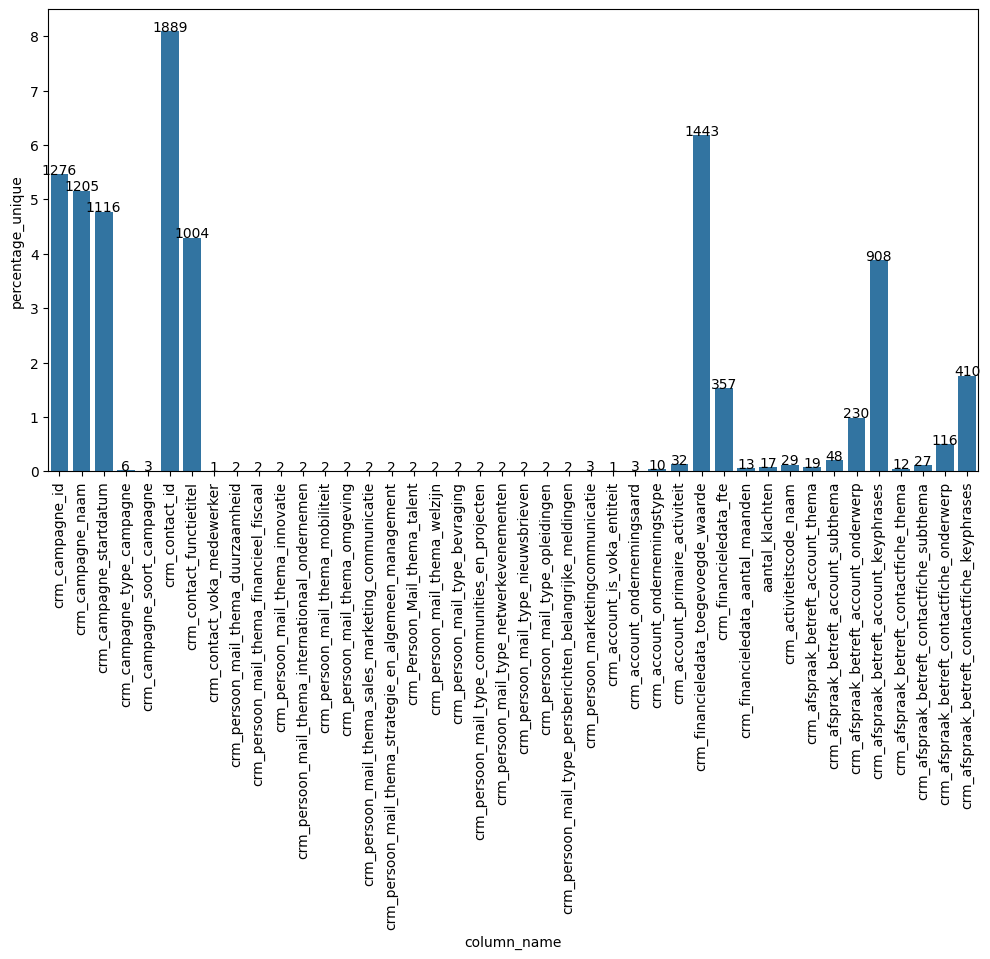

In [5]:
# Count the values

x_df_unique = pd.DataFrame(df.nunique()).reset_index()
x_df_unique.columns = ['column_name', 'unique_count']
# Add a column with the percentage of unique values
x_df_unique['percentage_unique'] = x_df_unique['unique_count'] / len(df) * 100
# Plot the information
plt.figure(figsize=(12, 6))
sns.barplot(x='column_name', y='percentage_unique', data=x_df_unique)
# Add the actual count of unique values on top of the bars
for i, row in x_df_unique.iterrows():
    plt.text(row.name, row.percentage_unique, row.unique_count, color='black', ha="center")
plt.xticks(rotation=90)
plt.show()

In [6]:
# Drop all single value columns
single_value_columns = x_df_unique[x_df_unique['unique_count'] == 1]['column_name'].tolist()
df.drop(single_value_columns, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23359 entries, 0 to 24429
Data columns (total 40 columns):
 #   Column                                                     Non-Null Count  Dtype         
---  ------                                                     --------------  -----         
 0   crm_campagne_id                                            23359 non-null  object        
 1   crm_campagne_naam                                          23359 non-null  object        
 2   crm_campagne_startdatum                                    23359 non-null  datetime64[ns]
 3   crm_campagne_type_campagne                                 23359 non-null  object        
 4   crm_campagne_soort_campagne                                23359 non-null  object        
 5   crm_contact_id                                             23359 non-null  object        
 6   crm_contact_functietitel                                   22661 non-null  object        
 7   crm_persoon_mail_thema_duurzaamheid 

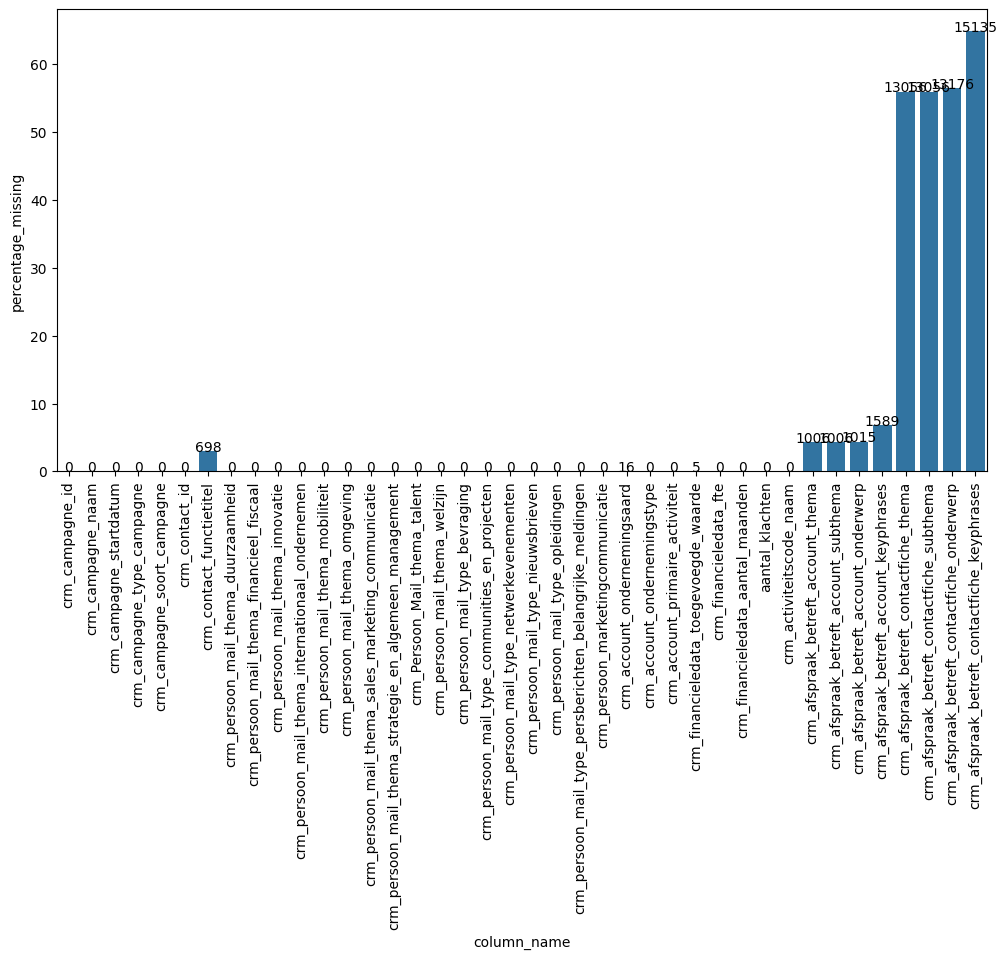

In [7]:
# Count the amount of missing values per column

x_df_missing = pd.DataFrame(df.isnull().sum()).reset_index()
x_df_missing.columns = ['column_name', 'missing_count']
# Add a column with the percentage of missing values
x_df_missing['percentage_missing'] = x_df_missing['missing_count'] / len(df) * 100
# Plot the information
plt.figure(figsize=(12, 6))
sns.barplot(x='column_name', y='percentage_missing', data=x_df_missing)
# Add the actual count of missing values on top of the bars
for i, row in x_df_missing.iterrows():
    plt.text(row.name, row.percentage_missing, row.missing_count, color='black', ha="center")

plt.xticks(rotation=90)
plt.show()

In [8]:
# Bring all of the columns to numeric values
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Get all of the columns that are not numeric
non_numeric_columns = df.select_dtypes(['object']).columns.tolist()
# Encode all of the columns that are not numeric
for column in non_numeric_columns:
    df[column] = le.fit_transform(df[column])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23359 entries, 0 to 24429
Data columns (total 40 columns):
 #   Column                                                     Non-Null Count  Dtype         
---  ------                                                     --------------  -----         
 0   crm_campagne_id                                            23359 non-null  int32         
 1   crm_campagne_naam                                          23359 non-null  int32         
 2   crm_campagne_startdatum                                    23359 non-null  datetime64[ns]
 3   crm_campagne_type_campagne                                 23359 non-null  int32         
 4   crm_campagne_soort_campagne                                23359 non-null  int32         
 5   crm_contact_id                                             23359 non-null  int32         
 6   crm_contact_functietitel                                   23359 non-null  int32         
 7   crm_persoon_mail_thema_duurzaamheid 

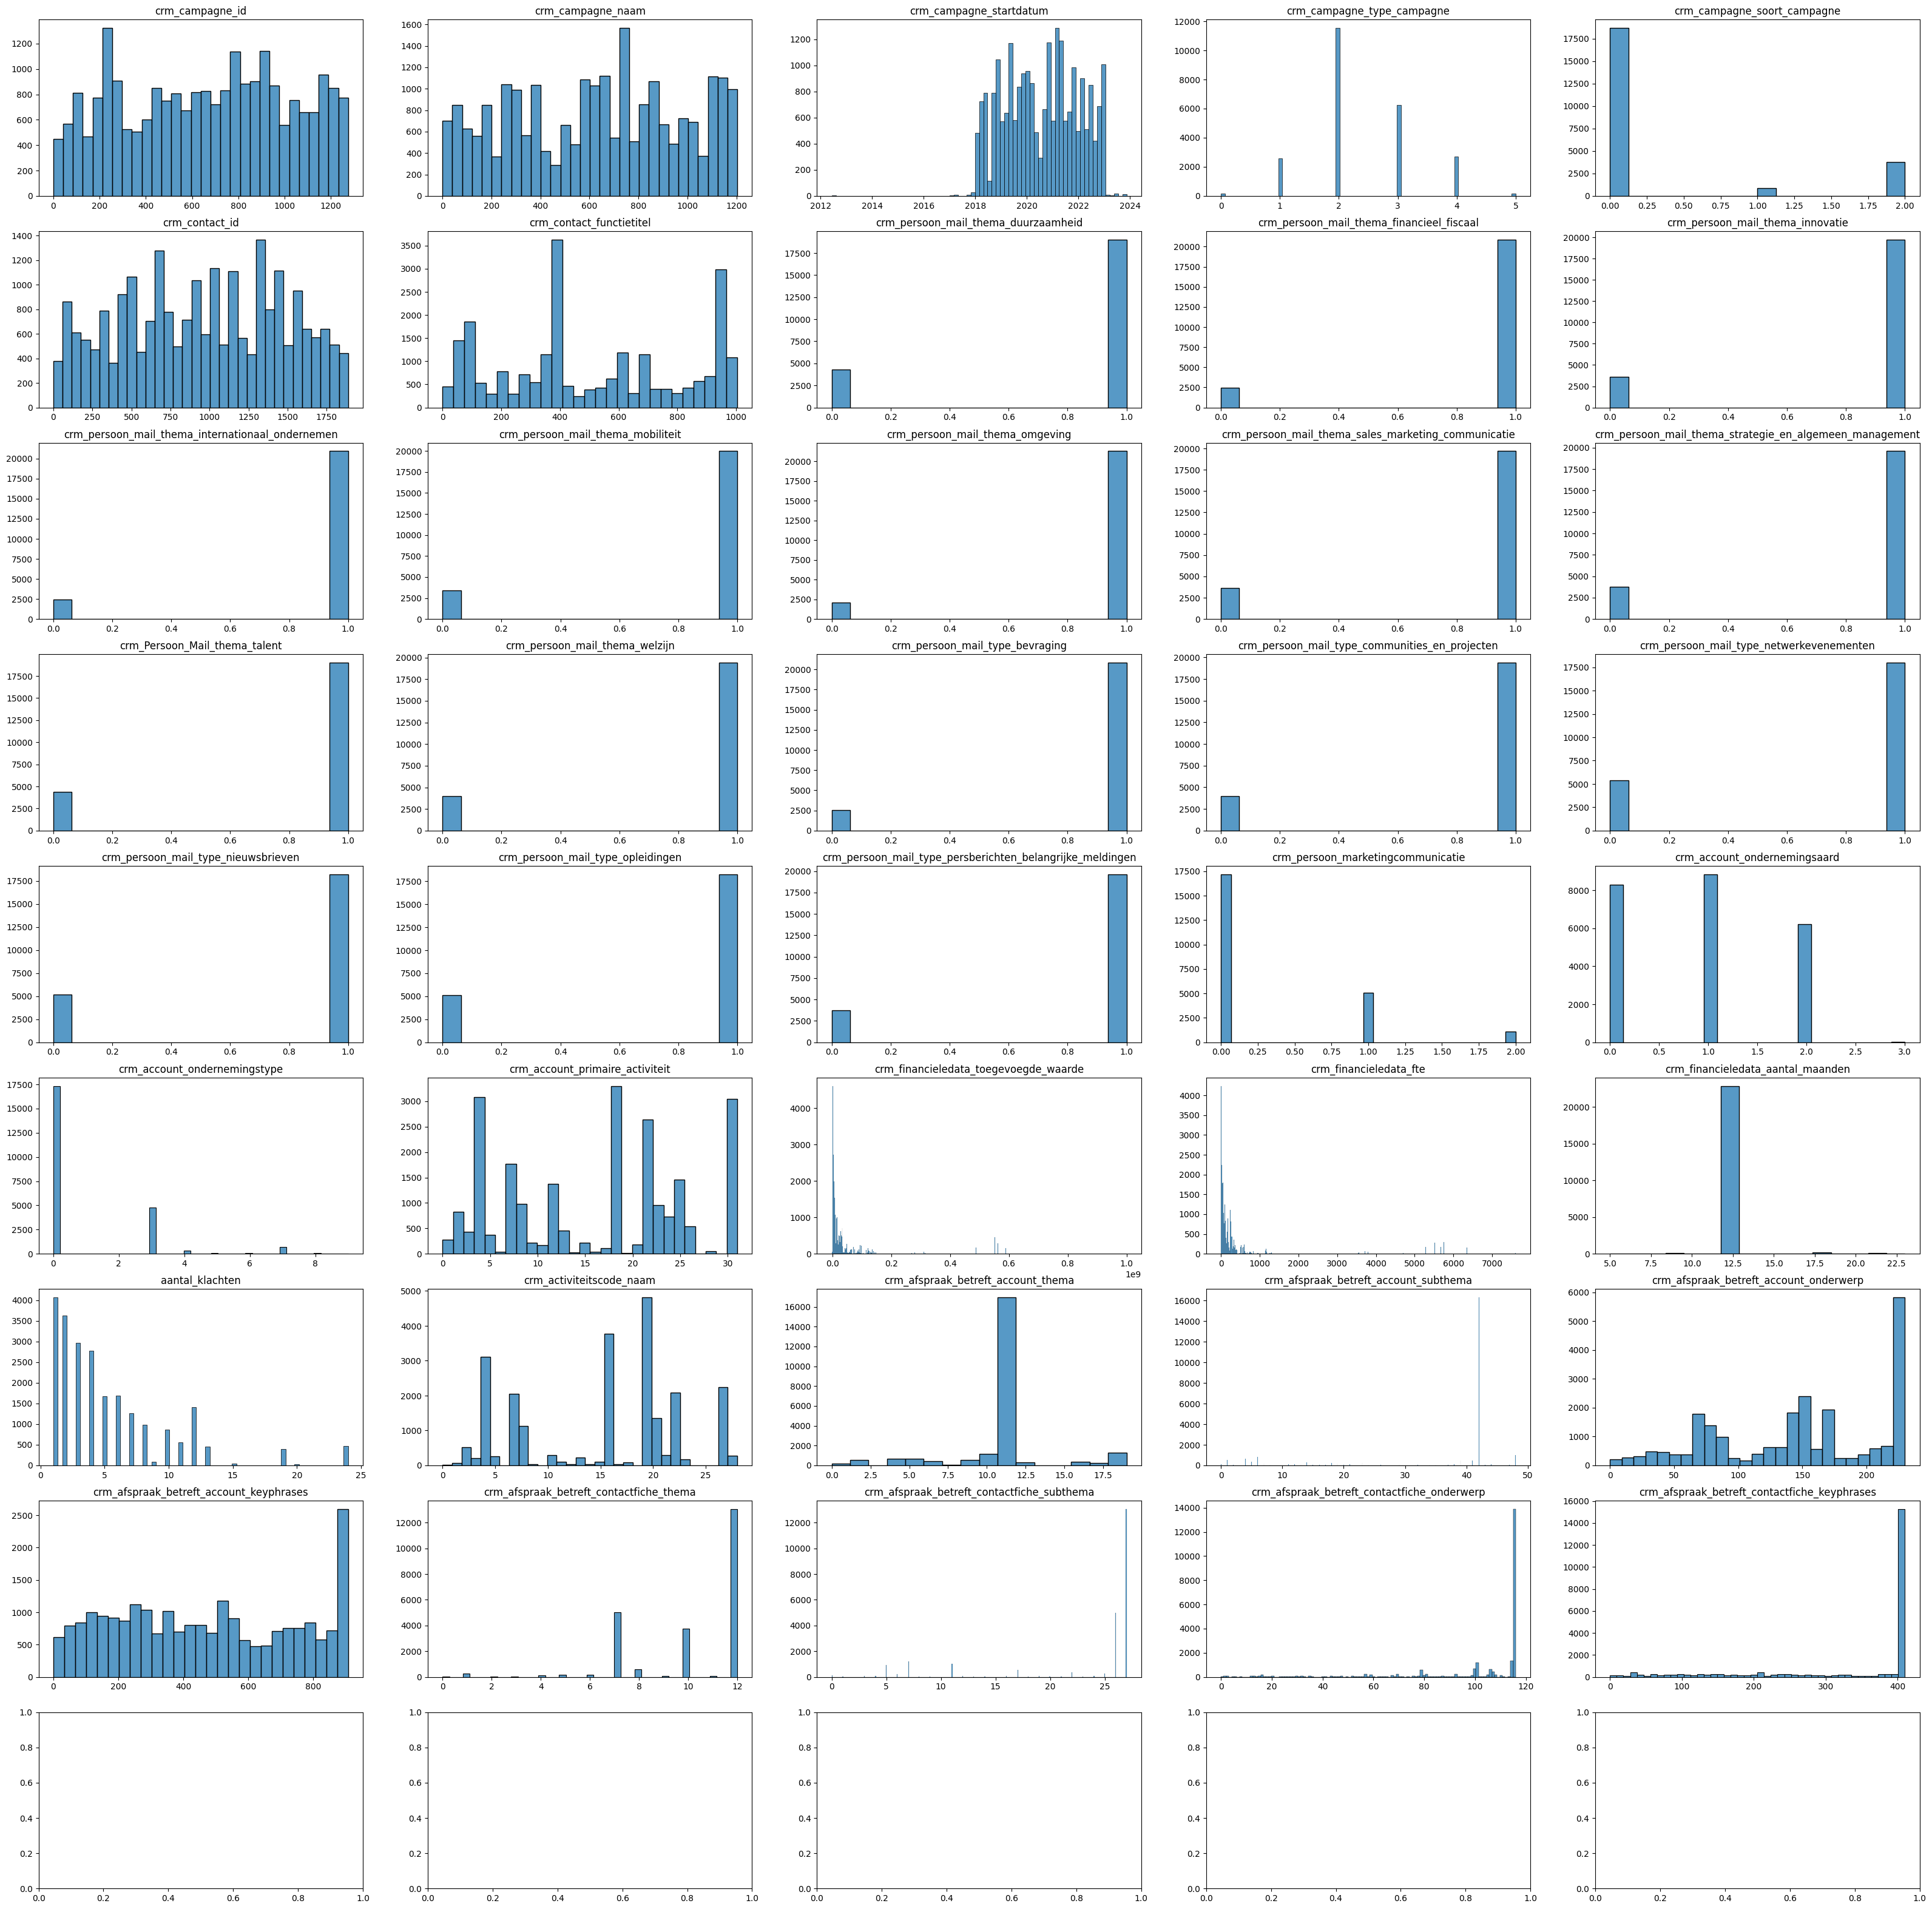

In [9]:
# Create a figure with subplots for each column
fig, axes = plt.subplots((len(df.columns) // 5) + 1, 5, figsize=(40, 40))

# Plot the distribution of each column
for i, column in enumerate(df.columns):
    sns.histplot(data=df, x=column, ax=axes[i // 5, i % 5])
    axes[i // 5, i % 5].set_title(column)
    axes[i // 5, i % 5].set_xlabel('')
    axes[i // 5, i % 5].set_ylabel('')

plt.show()

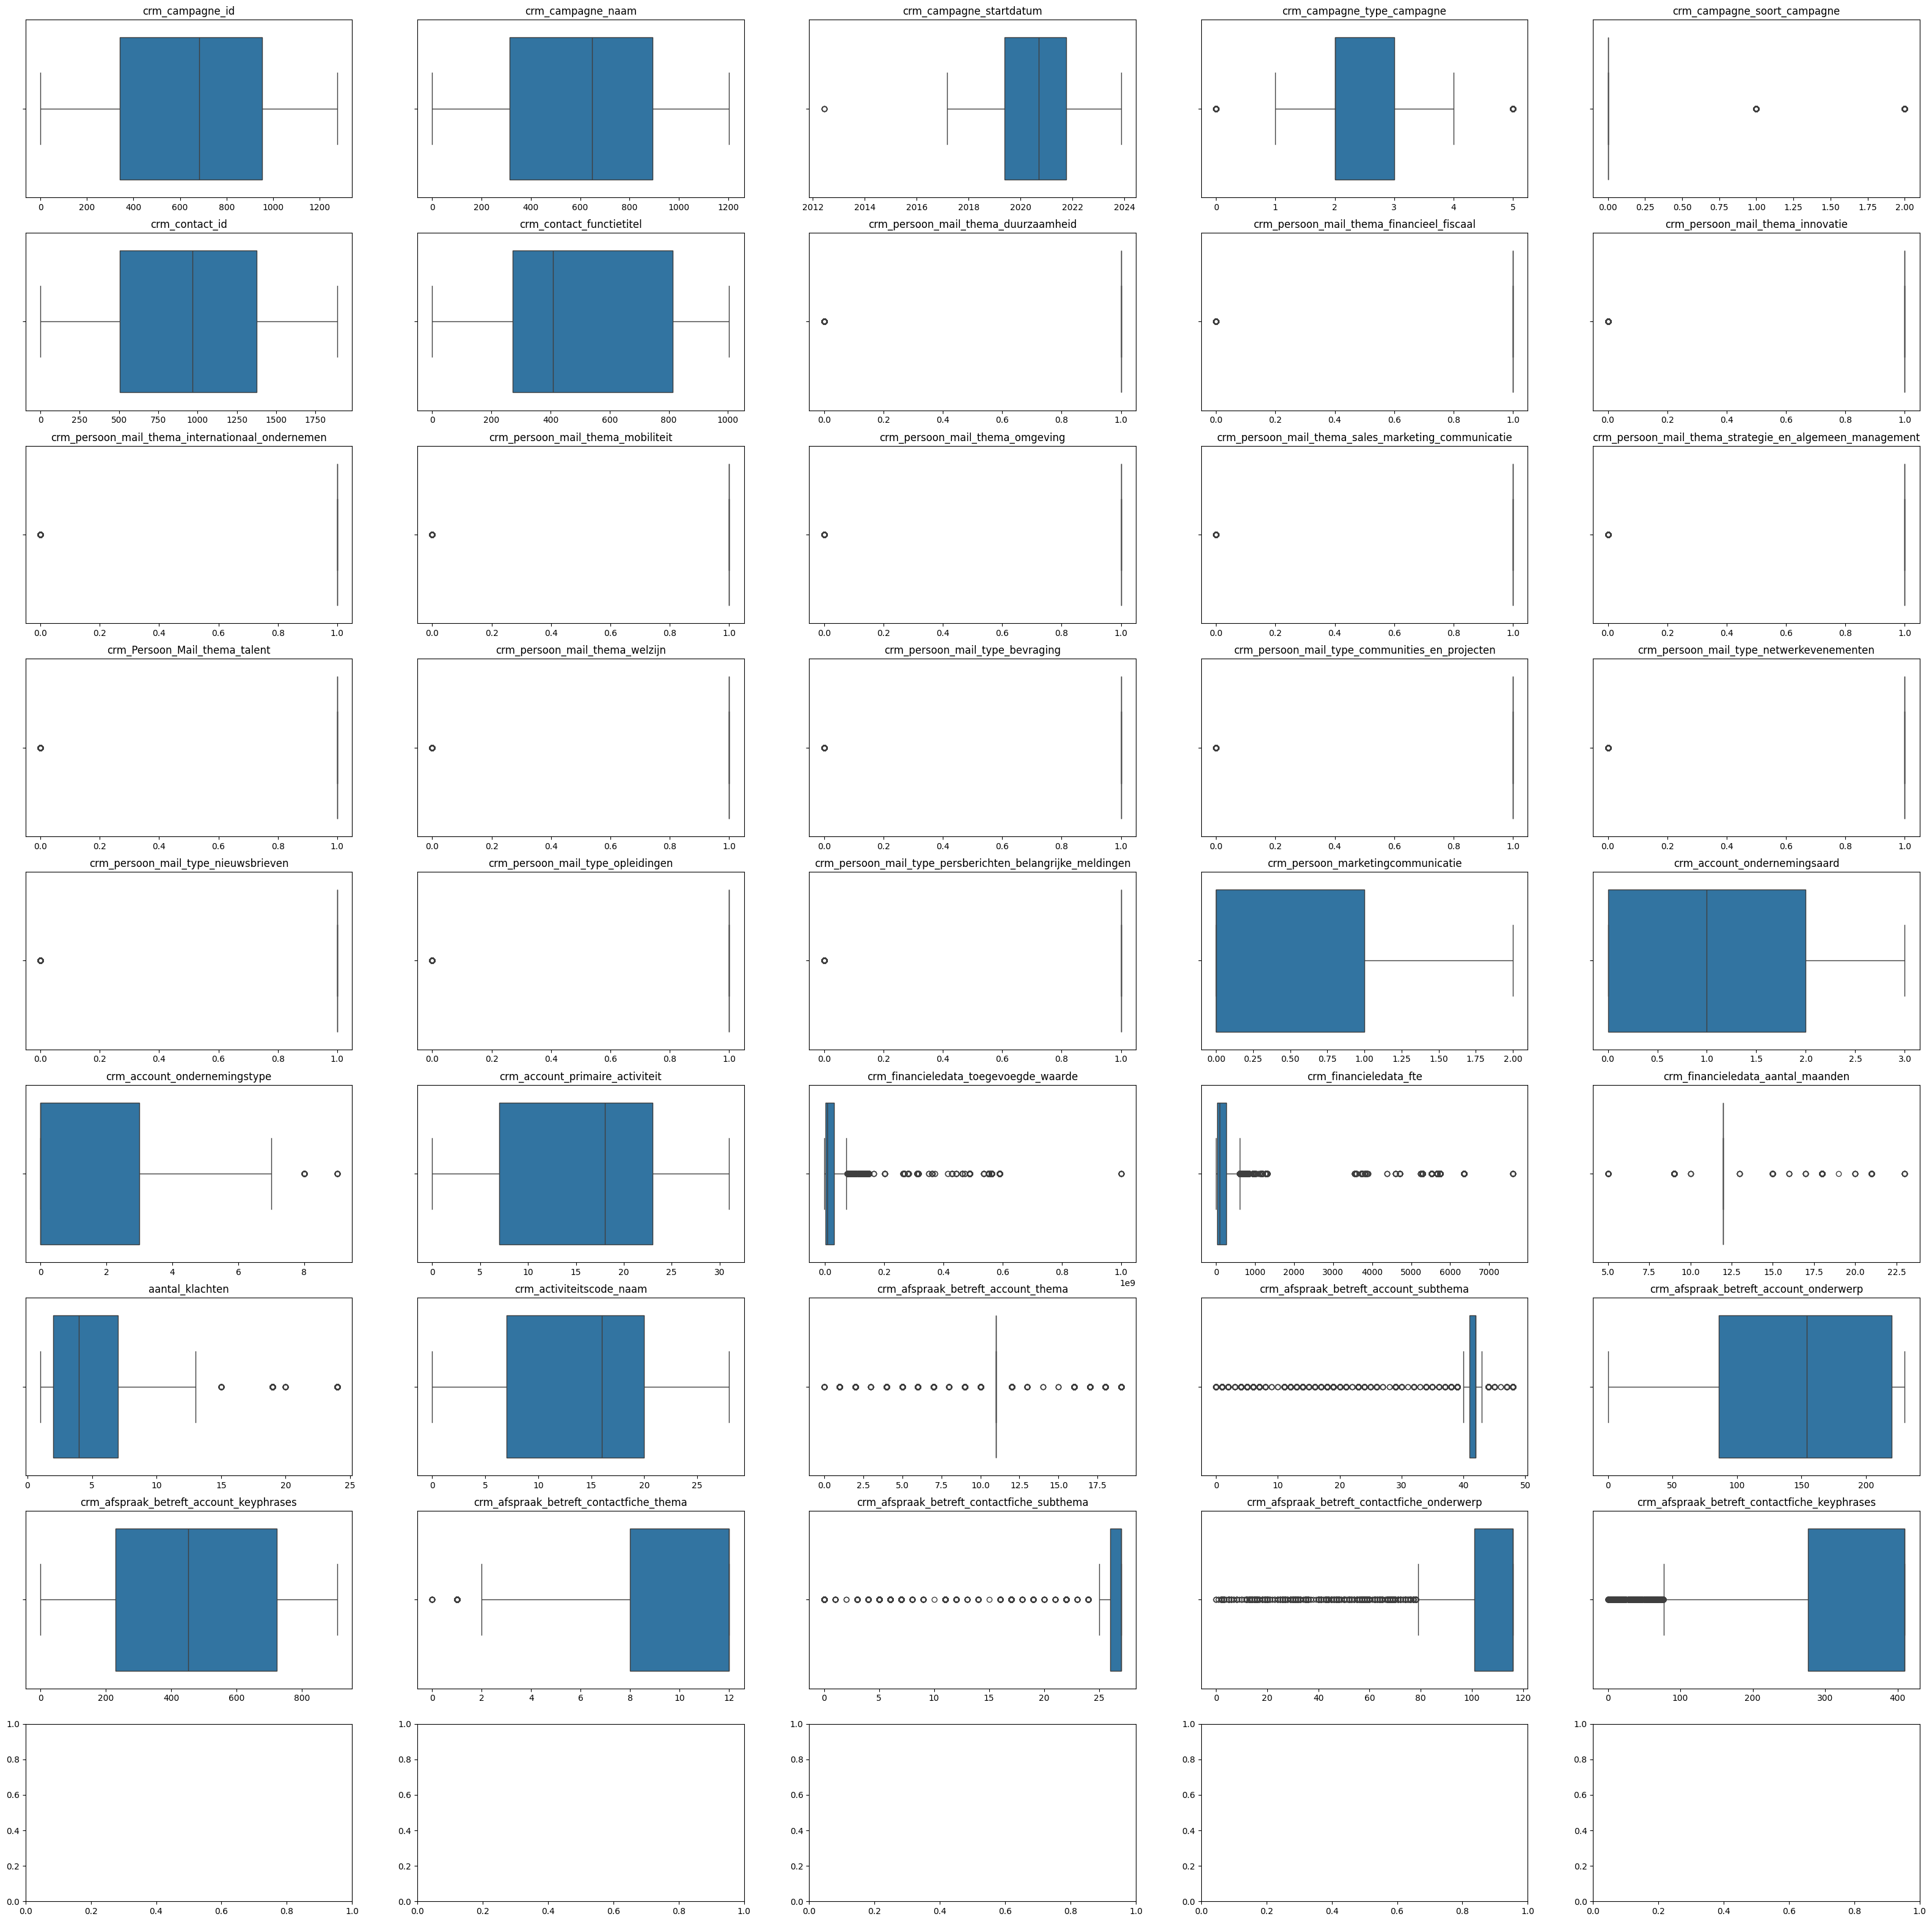

In [10]:
# Create a figure with subplots for each column
fig, axes = plt.subplots((len(df.columns) // 5) + 1, 5, figsize=(40, 40))

# Plot the Boxplot of each column

for i, column in enumerate(df.columns):
    sns.boxplot(data=df, x=column, ax=axes[i // 5, i % 5])
    axes[i // 5, i % 5].set_title(column)
    axes[i // 5, i % 5].set_xlabel('')
    axes[i // 5, i % 5].set_ylabel('')

plt.show()

# Heatmaps

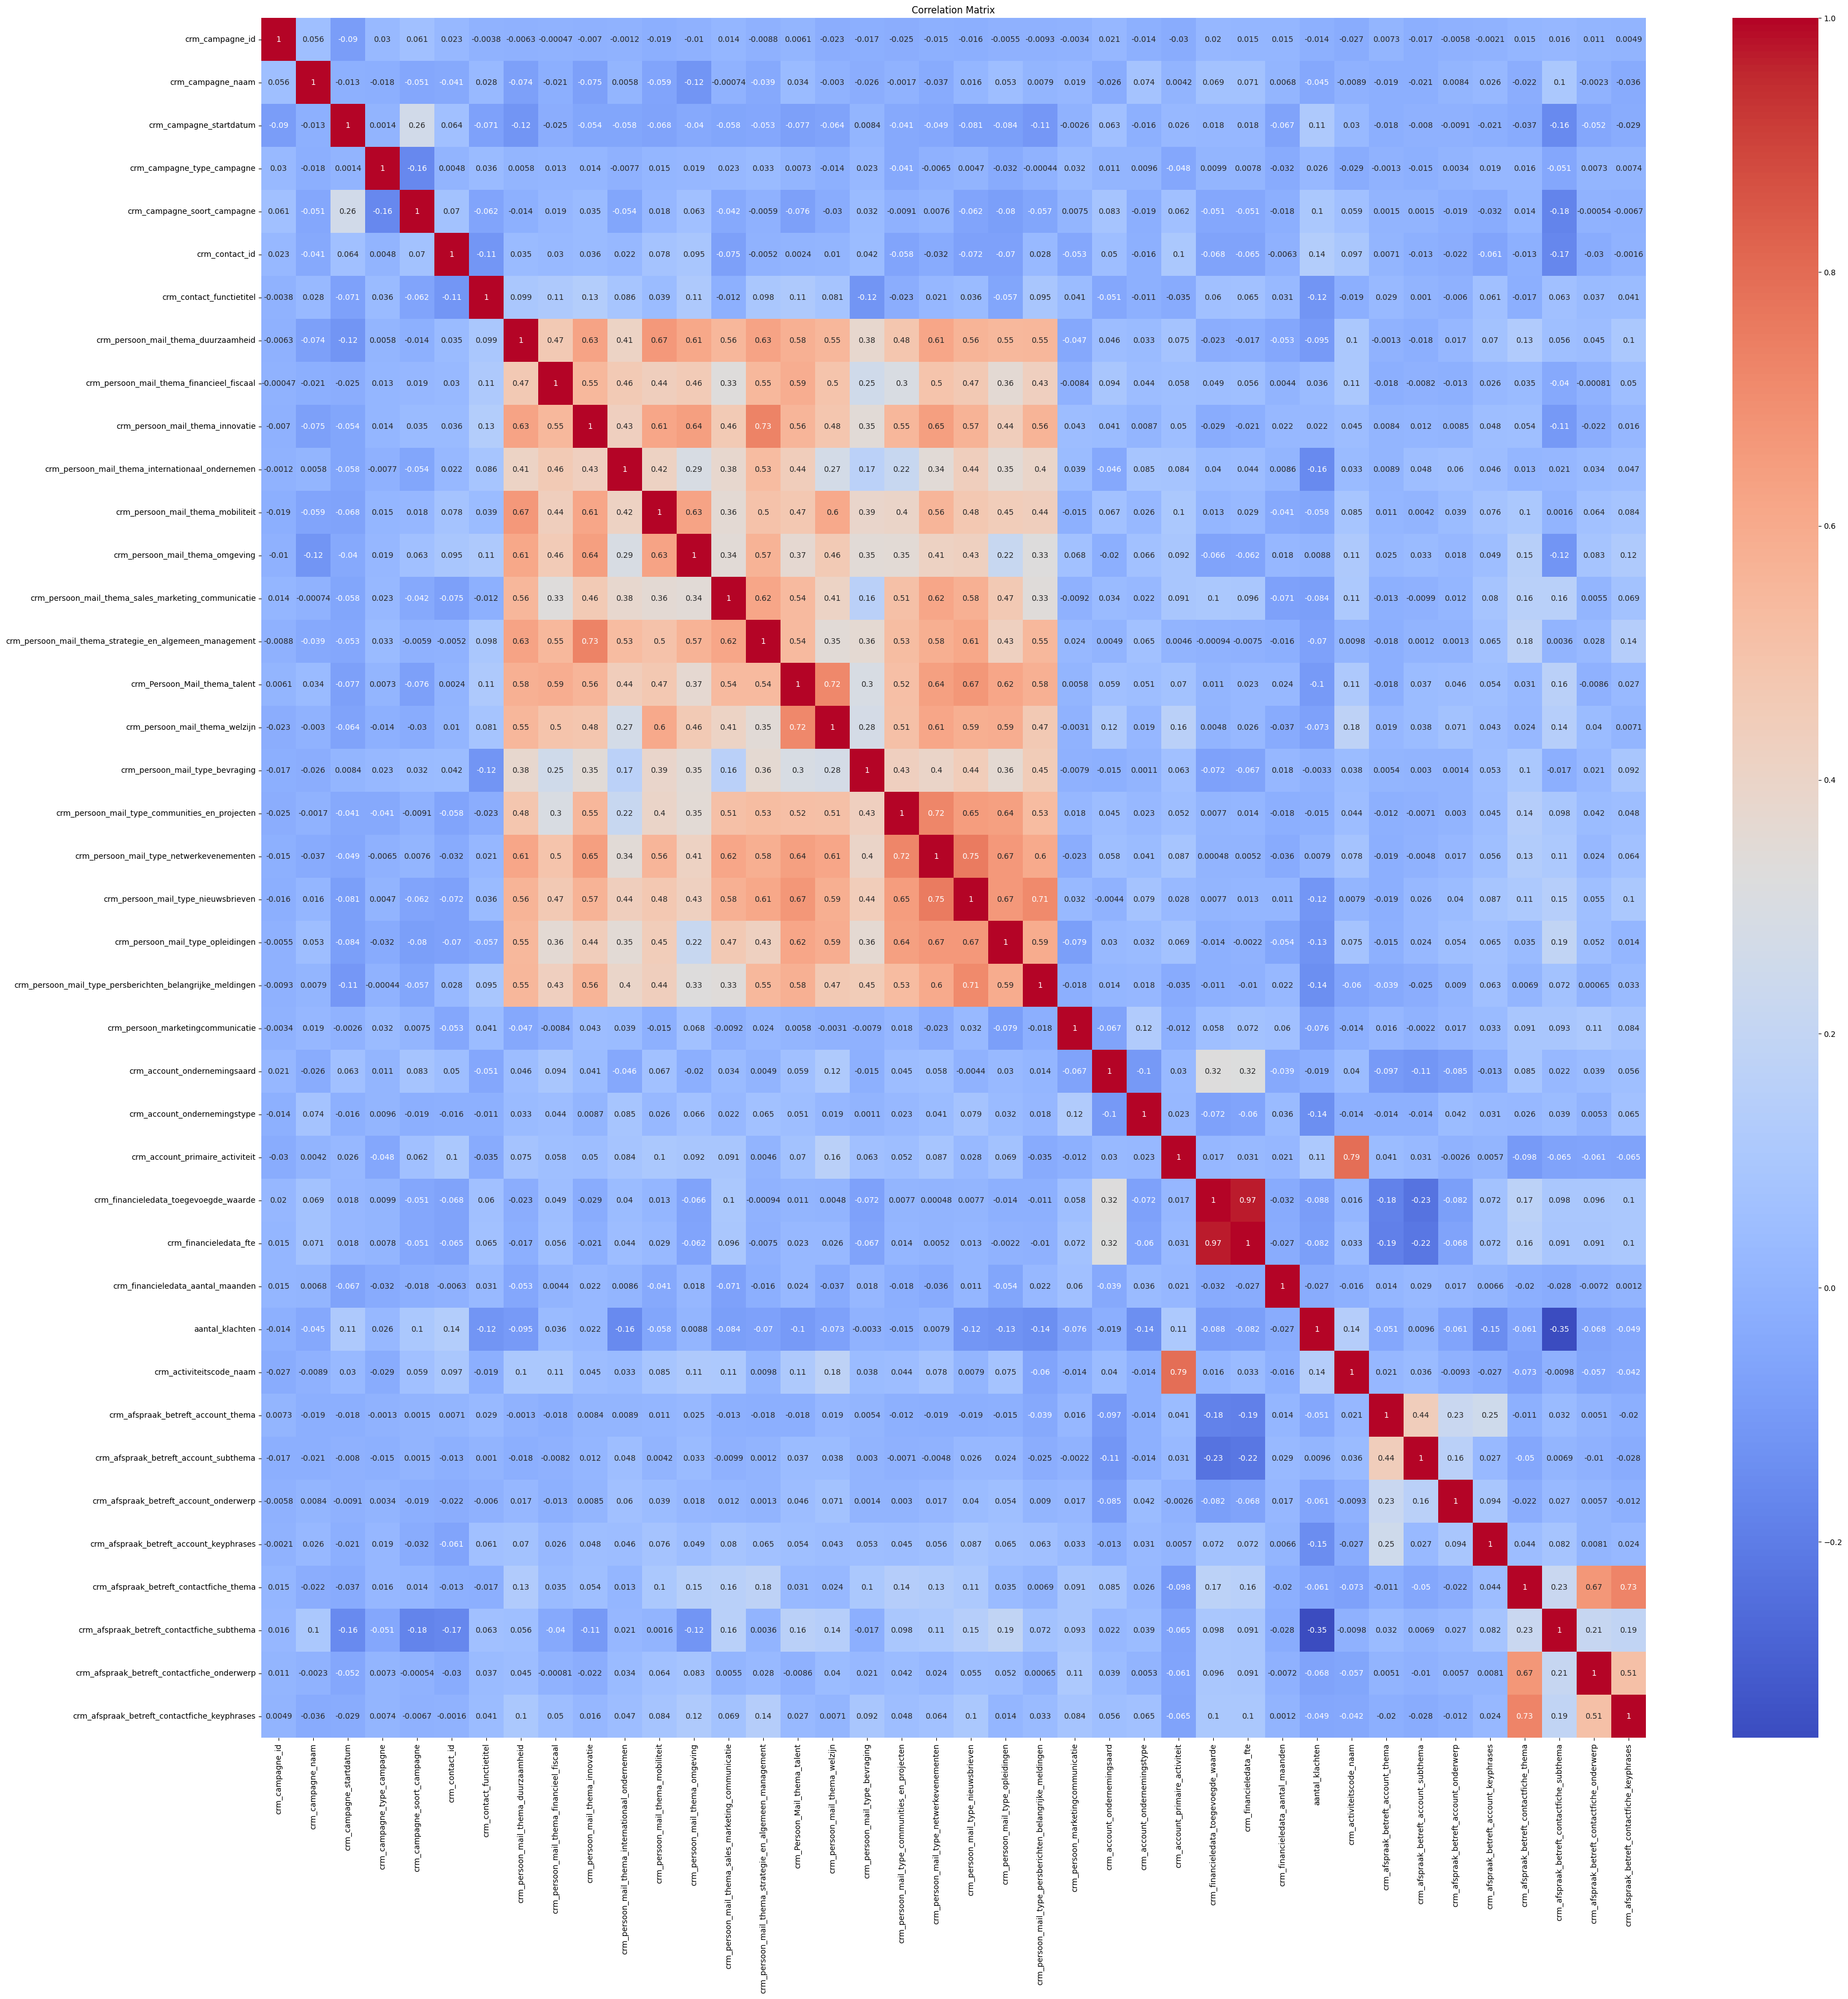

In [11]:
# Plot the a heatmap of the correlation of each column
fig, ax = plt.subplots(figsize=(40, 40))

sns.heatmap(df.corr(), annot=True, ax=ax, cmap='coolwarm')

ax.set_title('Correlation Matrix')
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()